In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
from nilearn import datasets, image

# === Define Subject IDs ===
# subject_ids = [
#     "sub-0001", "sub-0002", "sub-0003", "sub-0004", "sub-0005",
#     "sub-0006", "sub-0007", "sub-0008", "sub-0009", "sub-0011"
# ]
subject_ids = [
    "sub-0001", "sub-0002"
]


Shape of fMRI data: (80, 80, 36, 160)


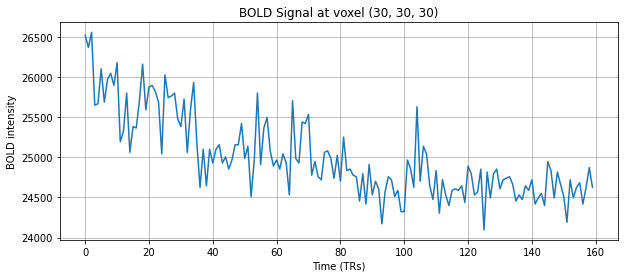

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt

# === Load NIfTI Image ===
img = nib.load("sub-0001_task-workingmemory_acq-seq_bold.nii.gz")
data = img.get_fdata()  # Shape: (X, Y, Z, T)

print("Shape of fMRI data:", data.shape)

# === Plot Raw Time Series for One Voxel ===
x, y, z = 30, 30, 30  # Pick voxel coordinates (adjust if needed)
voxel_ts = data[x, y, z, :]

plt.figure(figsize=(10, 4))
plt.plot(voxel_ts)
plt.title(f"BOLD Signal at voxel ({x}, {y}, {z})")
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD intensity")
plt.grid(True)
plt.show()


In [17]:
img = nib.load("sub-0001_task-restingstate_acq-seq_bold.nii.gz")
header = img.header
print(header.get_zooms())


(3.0, 3.0, 3.3, 2.0)


In [4]:
# === Construct File Paths ===
fmri_rest_files = [f"{sid}_task-restingstate_acq-seq_bold.nii.gz" for sid in subject_ids]
fmri_task_files = [f"{sid}_task-workingmemory_acq-seq_bold.nii.gz" for sid in subject_ids]
tsv_files = [f"{sid}.tsv" for sid in subject_ids]



In [5]:
# === Load Atlas and Define Masker ===
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(atlas.maps, standardize=True)


[get_dataset_dir] Dataset found in C:\Users\elena\nilearn_data\schaefer_2018


In [6]:
# === Define Function for Extracting Task-Only ROI Time Series ===
def extract_task_time_series(fmri_path, events_path, masker):
    img = nib.load(fmri_path)
    tr = img.header.get_zooms()[3]  # Extract TR (Repetition Time)

    events = pd.read_csv(events_path, sep="\t")
    task_indices = []

    for _, row in events.iterrows():
        onset = row["onset"]
        duration = row["duration"]
        start = int(np.floor(onset / tr))
        end = int(np.ceil((onset + duration) / tr))
        task_indices.extend(range(start, end))

    task_indices = sorted(set(task_indices))
    img_task = image.index_img(img, task_indices)
    time_series = masker.fit_transform(img_task)
    return time_series


In [7]:
# === Extract and Store Time Series per Subject ===
rest_dict = {}
task_dict = {}

for sid, rest_file, task_file, tsv_file in zip(subject_ids, fmri_rest_files, fmri_task_files, tsv_files):
    print(f"Processing {sid}...")
    
    # === Extract Resting ROI Time Series ===
    img_rest = nib.load(rest_file)
    rest_ts = masker.fit_transform(img_rest)
    rest_dict[sid] = rest_ts

    # === Extract Task ROI Time Series (from events) ===
    task_ts = extract_task_time_series(task_file, tsv_file, masker)
    task_dict[sid] = task_ts

print("\n Time series extraction complete.")


Processing sub-0001...
Processing sub-0002...

 Time series extraction complete.


In [8]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA
import numpy as np

# === Function for Computing PCCA Matrix for One Subject ===
def compute_pcca_matrix(subject_data, num_components=3):
    num_rois = subject_data.shape[1]
    pcca_results = np.zeros((num_rois, num_rois))

    for i in range(num_rois):
        for j in range(i + 1, num_rois):
            X = subject_data[:, i].reshape(-1, 1)
            Y = subject_data[:, j].reshape(-1, 1)

            remaining_indices = [idx for idx in range(num_rois) if idx != i and idx != j]
            Z = subject_data[:, remaining_indices]

            pca = PCA(n_components=num_components)
            Z_pca = pca.fit_transform(Z)

            def remove_confound(Α, Z_pca):
                reg = LinearRegression().fit(Z_pca, Α)
                return Α - reg.predict(Z_pca)

            X_residual = remove_confound(X, Z_pca)
            Y_residual = remove_confound(Y, Z_pca)

            cca = CCA(n_components=1)
            X_c, Y_c = cca.fit_transform(X_residual, Y_residual)

            pcca_value = np.corrcoef(X_c.T, Y_c.T)[0, 1]
            pcca_results[i, j] = pcca_value
            pcca_results[j, i] = pcca_value

    return pcca_results

In [9]:
# === Run Sequentially Across Subjects ===
pcca_rest_all = {}
pcca_task_all = {}

for sid in subject_ids:
    print(f"Computing PCCA for {sid}...")
    rest_ts = rest_dict[sid]
    task_ts = task_dict[sid]

    pcca_rest = compute_pcca_matrix(rest_ts)
    pcca_task = compute_pcca_matrix(task_ts)

    pcca_rest_all[sid] = pcca_rest
    pcca_task_all[sid] = pcca_task


Computing PCCA for sub-0001...
Computing PCCA for sub-0002...


In [10]:
def average_pcca_matrices(pcca_dict):
    """
    Υπολογίζει τον μέσο PCCA πίνακα από λεξικό {subject_id: matrix}
    """
    matrices = list(pcca_dict.values())
    return np.mean(matrices, axis=0)


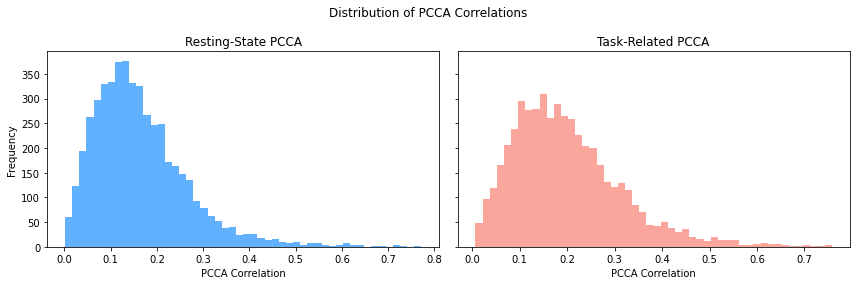

In [20]:
import numpy as np
import matplotlib.pyplot as plt
mean_pcca_rest = average_pcca_matrices(pcca_rest_all)
mean_pcca_task = average_pcca_matrices(pcca_task_all)
# Extract upper triangle values (excluding diagonal)
def extract_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

rest_values = extract_upper_triangle(mean_pcca_rest)
task_values = extract_upper_triangle(mean_pcca_task)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Histogram for Rest
axes[0].hist(rest_values, bins=50, color='dodgerblue', alpha=0.7)
axes[0].set_title("Resting-State PCCA")
axes[0].set_xlabel("PCCA Correlation")
axes[0].set_ylabel("Frequency")

# Histogram for Task
axes[1].hist(task_values, bins=50, color='salmon', alpha=0.7)
axes[1].set_title("Task-Related PCCA")
axes[1].set_xlabel("PCCA Correlation")

plt.suptitle("Distribution of PCCA Correlations")
plt.tight_layout()
plt.show()


[get_dataset_dir] Dataset found in C:\Users\elena\nilearn_data\schaefer_2018


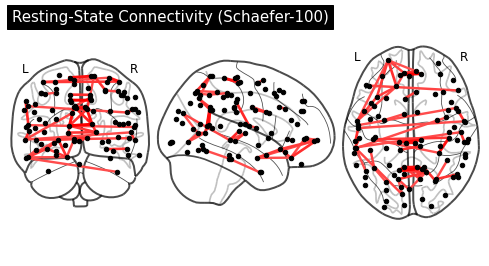

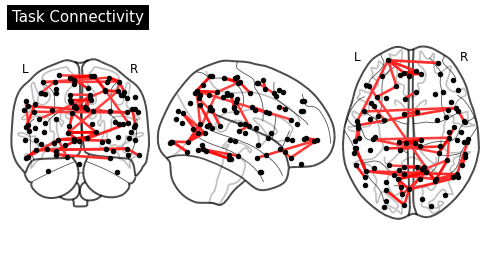

In [11]:
from nilearn import datasets, plotting

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, resolution_mm=1)
atlas_img = atlas['maps']

masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True)
masker.fit()

coords = plotting.find_parcellation_cut_coords(labels_img=atlas_img)
import numpy as np

mean_pcca_rest = average_pcca_matrices(pcca_rest_all)
mean_pcca_task = average_pcca_matrices(pcca_task_all)

np.fill_diagonal(mean_pcca_rest, 0)
plotting.plot_connectome(
    mean_pcca_rest,
    coords,
    title='Resting-State Connectivity (Schaefer-100)',
    edge_threshold="99%",  
    node_size=20,
    node_color="black"
)

plotting.plot_connectome(
    mean_pcca_task,
    coords,
    title='Task Connectivity',
    edge_threshold="99%",
    node_size=20,
    node_color="black"
)



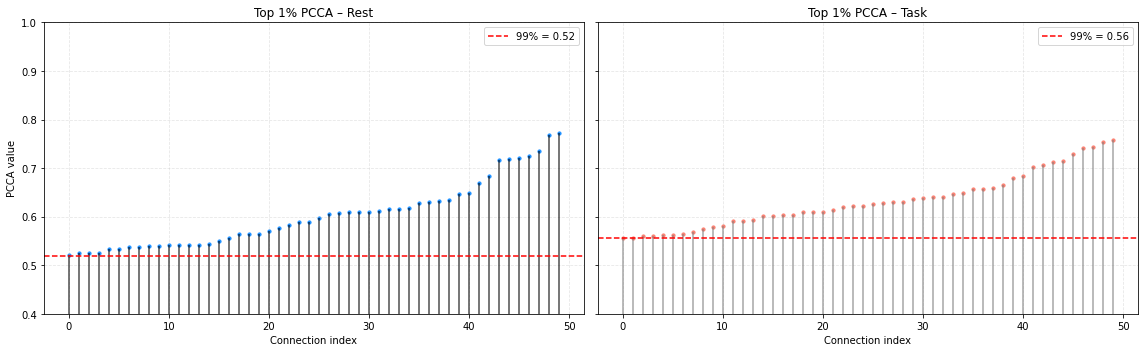

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Extract upper triangle (excluding diagonal)
def extract_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

# Extract and sort all PCCA values
task_values = extract_upper_triangle(mean_pcca_task)
task_threshold = np.percentile(task_values, 99)
task_filtered = task_values[task_values > task_threshold]
task_sorted = np.sort(task_filtered)

# Get Rest values as before
rest_values = extract_upper_triangle(mean_pcca_rest)
rest_threshold = np.percentile(rest_values, 99)
rest_filtered = rest_values[rest_values > rest_threshold]
rest_sorted = np.sort(rest_filtered)


fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Plot REST
axes[0].vlines(np.arange(len(rest_sorted)), ymin=0, ymax=rest_sorted, color='black', alpha=0.7)
axes[0].scatter(np.arange(len(rest_sorted)), rest_sorted, color='dodgerblue', s=10)
axes[0].axhline(rest_threshold, color='red', linestyle='--', label=f"99% = {rest_threshold:.2f}")
axes[0].set_title("Top 1% PCCA – Rest")
axes[0].set_xlabel("Connection index")
axes[0].set_ylabel("PCCA value")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].set_ylim(0.4, 1.0)

# Plot TASK
axes[1].vlines(np.arange(len(task_sorted)), ymin=0, ymax=task_sorted, color='gray', alpha=0.7)
axes[1].scatter(np.arange(len(task_sorted)), task_sorted, color='salmon', s=10)
axes[1].axhline(task_threshold, color='red', linestyle='--', label=f"99% = {task_threshold:.2f}")
axes[1].set_title("Top 1% PCCA – Task")
axes[1].set_xlabel("Connection index")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)
axes[1].set_ylim(0.4, 1.0)

plt.tight_layout()
plt.show()
